In [27]:
import serial                                        #Serial imported for Serial communication
import time                                          #Required to use delay functions   
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

f = 0.0034 #TODO
T = 0.1 #TODO
template = None #TODO
numRotations = 1
sensorWidth = 0.00276
#TODO, MAYBE CENTER WITH THE CENTER OF THE CAR???? INSTEAD OF CYCLOPIAN EYE

def nonMaxSuppress(res, loc):
  indicesToKeep = []
  for i in range(len(loc[0])):
      x, y = loc[0][i], loc[1][i]
      if res[x][y] > res[x - 1][y - 1] and res[x][y] > res[x - 1][y] and res[x][y] > res[x - 1][y + 1]\
      and res[x][y] > res[x][y - 1] and res[x][y] > res[x - 1][y + 1]\
      and res[x][y] > res[x + 1][y - 1] and res[x][y] > res[x + 1][y] and res[x][y] > res[x + 1][y + 1]:
          indicesToKeep.append(i)
  return [loc[0][indicesToKeep], loc[1][indicesToKeep]]

def findIntersection(loc1, loc2):
  xs, ys = [], []
  for i in range(len(loc1[0])):
      x, y = loc1[0][i], loc1[1][i]
      for j in range(len(loc2[0])):
          z, t = loc2[0][j], loc2[1][j]
          if x == z and t == y:
              xs.append(z)
              ys.append(y)
              break
  return (xs, ys)

def processImages(theta = 0, image1 = 'imageL.jpg', image2 = 'imageR.jpg', template = 'template.png'):
  #theta represents the angle with respect to the original orientation of the car.   
  img_rgb = cv.imread(image1)
  img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
  print("OG image")
  plt.imshow(img_gray)
  plt.show()

  template = cv.imread(template, 0)
  plt.imshow(img_rgb)
  plt.show()
  plt.imshow(template)
  #plt.show()

  w, h = template.shape[::-1]
  res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
  maxes = (res == ndimage.filters.maximum_filter(res, size = (50, 50)))
  threshold = 0.6
  loc = np.where(res >= threshold)
  loc2 = np.where(maxes)

  loc = findIntersection(loc, loc2)

  fireTemplates = []
  for i in range(len(loc[0])):
    x, y = loc[0][i], loc[1][i]
    fireTemplates.append(img_gray[x:x+w, y:y+h] )

  for pt in zip(*loc[::-1]):
      cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
  cv.imwrite('res.png',img_rgb)

  img_rgb = cv.imread(image2) #match in the other camera
  img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
  e = 20                 #line search leeway


  depths = []
  Xs = []
  for i in range(len(loc[0])):
      x = loc[0][i]
      y = loc[1][i]
      fireTemplate = fireTemplates[i]
      img2slice = img_gray[x - e :x+w + e, :]
      #print("fireTemplate", i)
      #plt.imshow(fireTemplate)
      #plt.show()
      #plt.imshow(img2slice)
      #plt.show()
      #plt.imshow(img_gray)
      #plt.show()
      res = cv.matchTemplate(img2slice,fireTemplate,cv.TM_CCOEFF_NORMED)
      locations = []
      for i in range(len(res)):
            for j in range(len(res[0])):
                locations.append((i, j))
      location = max(locations, key = lambda x: res[x[0]][x[1]])

      diff = location[1] - y #i think its y
      xdiff = diff / 480 * sensorWidth
        
      depth = f * T / xdiff

      y -= 240
      X = y/480*sensorWidth*depth/f  #x is the 3d location of the fire with respect to current orientation.
      X = X - (T / 2) #normalize to cyclopian eye

      #NOW, we rotate back to the original coordinate system.
      rotate = np.array([[math.cos(theta), -math.sin(theta)],
                         [math.sin(theta), math.cos(theta)]])
      rotXZ = rotate @ np.array([X, depth])
      X = rotXZ[0]
      Z = rotXZ[1]

      Xs.append(X)
      depths.append(Z)

  return depths, Xs 

def cleanDuplicates(Xs, Zs):
  realZs = []
  realXs = []
  for X, Z in zip(Xs, Zs):
    unique = True
    for X2, Z2 in zip(realXs, realZs):
      dist = np.linalg.norm(np.array([Z, X]), np.array([Z2, X2]))
      if dist <= 0.1: #<- TODO
        unique = False
        break
    if unique:
      realZs.append(Z)
      realXs.append(X)
  return realXs, realZs


def findFires(rotations):
  #i is how many rotations we do. 
  #i = 4 means we do four 90 degree turns
  Zs = []
  Xs = []

  for i in range(rotations):
    theta = (360 / rotations) * i

    IMG1 = TAKEPICTURE()

    ArduinoUnoSerial.write('4')
    time.sleep(5)

    IMG2 = TAKEPICTURE()

    ArduinoUnoSerial.write('5')
    time.sleep(5)

    

    #TODO: TAKE TWO PICTURES AND SAVE TO IMG1, IMG2
    IMG1 = ''
    IMG2 = ''
    temp = processImages(theta, image1 = IMG1, image2 = IMG2, template = template)
    Zs += temp[1]
    Xs += temp[0]
  if not Zs:
    return None
  #At this point, there will surely be duplicates that are pretty close. Let's get rid of the duplicates
  Xs, Zs = cleanDuplicates(Xs, Zs)

  locations = zip(Xs, Zs)
  minLoc = min(range(len(locations)), key = lambda x: np.linalg.norm(np.array(locations[x])))

  return minLoc #X and Z of closest fire

def findAndTargetFire():
    res = findFires(numRotations)
    if not res:
        return 0
    X, Z = res
    dist = np.linalg.norm(np.array([X, Z]))
    if Z >= 0 and X >= 0: #Q1
        theta = 90 - arctan(Z / X) #theta with respect to X axis
    if Z < 0 and X >= 0: 
        theta = 90 - arctan(Z / X) #Q4
    if Z < 0 and X < 0:
        theta = 90 + arctan(Z / X) #Q3
        theta = -theta
    else:
        theta = 90 + arctan(Z / X) #Q2
        theta = -theta
    ArduinoUnoSerial.write('1' + str(theta)) #rotate by theta
    ArduinoUnoSerial.write('2' + str(dist)) #drive by distance
    ArduinoUnoSerial.write('3') #kill fire
    return 1

def killFires():
    while(findAndTargetFire()):
        pass



def main():
    ArduinoUnoSerial = serial.Serial('com15',9600)       #Create Serial port object called ArduinoUnoSerialData time.sleep(2)                                                             #wait for 2 secounds for the communication to get established
    killFires()
      

OG image


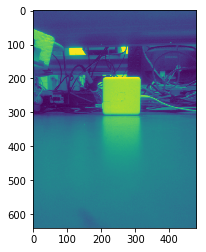

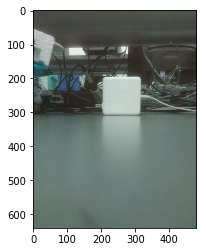

([0.5279503105590063], [-0.07500000000000001])

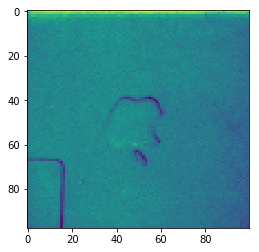

In [28]:
processImages(theta = 0, image1 = 'testL.jpg', image2 = 'testR.jpg', template = 'testTemplate.jpg')